In [1]:
import os
import copy
import functools
import win32com.client

import lmfit
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import linregress
from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model, mcmc
from sivqed.models.fitter import single_siv_ref, two_siv_ref, cavity_ref, three_siv_ref
from sivqed.models.diffusion import diffused_siv_peaks, plot_diffused_contrasts

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
datafolder_path = win32com.client.Dispatch("WScript.Shell").CreateShortCut("../data.lnk").Targetpath
cavity_path = datafolder_path + "/20210907_spectrometer_cavity\Bb03_cavity_1_1800gr_2000ms_737.00nm_2.00mm/"
cavity_file = "Bb03_cavity_1_1800gr_2000ms_737.00nm_2.00mm.txt"

# Plotting Cavity

In [72]:
!jt -t grade3

Text(0.5, 1.0, 'Cavity Scan')

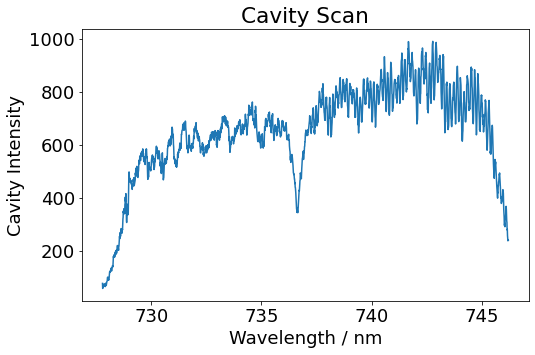

In [64]:
DARK_COUNTS = 924

cavity_data = np.loadtxt(cavity_path + cavity_file, skiprows=2, delimiter=",")
cavity_wls = cavity_data[:, 0]
cavity_intensity = cavity_data[:, 1] - DARK_COUNTS

plt.figure(figsize=[8, 5])
plt.plot(cavity_wls, cavity_intensity)
plt.xlabel("Wavelength / nm")
plt.ylabel("Cavity Intensity")
plt.title("Cavity Scan")

Text(0.5, 1.0, 'Cavity Scan')

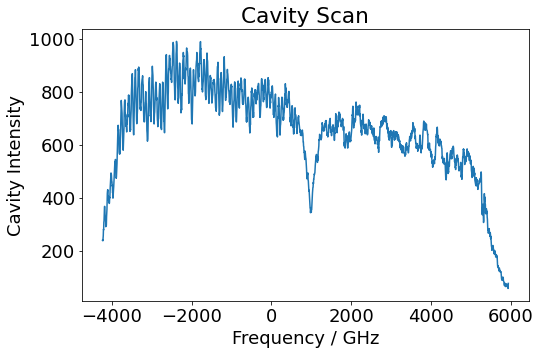

In [65]:
# Convert from nm to Hz
cavity_freqs = 2.998E8 / (cavity_wls * 1E-9)
# Re-center, convert to GHz
cavity_freqs = (cavity_freqs - 406E12) / 1E9

cavity_freqs = np.array(cavity_freqs)
cavity_intensity = np.array(cavity_intensity)

plt.figure(figsize=[8, 5])
plt.plot(cavity_freqs, cavity_intensity)
plt.xlabel("Frequency / GHz")
plt.ylabel("Cavity Intensity")
plt.title("Cavity Scan")

## Filtered Cavity

In [66]:
def not_in_range(arr, ranges):
    """ Returns indices of `arr` that do not lie in the list 
        of (start, end) tuples in ranges. """
    
    conditions = []
    # AND of (x < start OR x > end) leads to all x that are 
    # outside of the (start, end) ranges.
    for start, end in ranges:
        conditions.append((arr < start) | (arr > end)) 
    return np.where(functools.reduce(np.logical_and, conditions))

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 150
    # data points      = 1207
    # variables        = 4
    chi-square         = 8472011.89
    reduced chi-square = 7042.40390
    Akaike info crit   = 10697.6571
    Bayesian info crit = 10718.0407
[[Variables]]
    w_c:    995.040982 +/- 7.16896858 (0.72%) (init = 1000)
    k_in:   119.388392 +/- 10.9408339 (9.16%) (init = 100)
    k_tot:  138.644868 +/- 11.6684113 (8.42%) (init = 200)
    A:      721.985119 +/- 2.82851048 (0.39%) (init = 1000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.997
    C(k_tot, A)    =  0.394
    C(k_in, A)     =  0.371
    C(w_c, k_tot)  =  0.169
    C(w_c, k_in)   =  0.169


Text(0, 0.5, 'Counts')

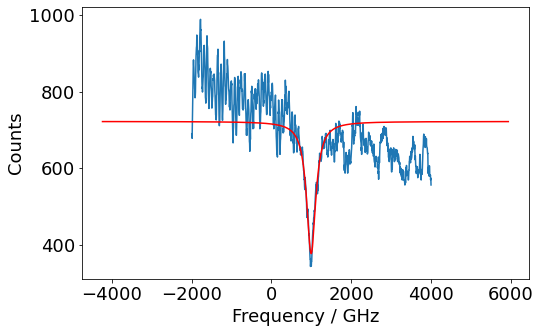

In [85]:
# Range of frequencies to filter out to remove cavity tails
filter_range = [(-4500, -2000), (4000, 6000)]

# Filter the freq and intensity values
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

#####
params = Parameters()
params.add_many(
    Parameter('w_c', value=1000, min=800, max=1200),
    Parameter('k_in', value=100, min=50, max=1000),
    Parameter('k_tot', value=200, min=0, max=1000),
    Parameter('A', value=1000, min=500, max=2000),
    Parameter('B', value=0, vary=False),
)

cavity_filtered_results = cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered, method="lbfgsb")
lmfit.report_fit(cavity_filtered_results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs, cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs), 'r')
plt.xlabel("Frequency / GHz")
plt.ylabel("Counts")

# Tilted Cavity

In [68]:
def tilted_cavity_ref(w, w_c, k_in, k_tot, A, B, m):
    return (m * (w - w_c) + A) * Cavity.reflectance_fn(
                        w, -1, [],
                        w_c, k_in, k_tot
                        ) + B

tilted_cavity_ref_model = lmfit.Model(tilted_cavity_ref)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 318
    # data points      = 1207
    # variables        = 5
    chi-square         = 2308926.38
    reduced chi-square = 1920.90381
    Akaike info crit   = 9130.57478
    Bayesian info crit = 9156.05424
[[Variables]]
    w_c:    987.754803 +/- 3.65992343 (0.37%) (init = 1000)
    k_in:   117.923030 +/- 5.57560722 (4.73%) (init = 100)
    k_tot:  137.047969 +/- 5.94636867 (4.34%) (init = 200)
    A:      721.702896 +/- 1.47731623 (0.20%) (init = 1000)
    B:      0 (fixed)
    m:     -0.04138375 +/- 7.3062e-04 (1.77%) (init = -10)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.997
    C(k_tot, A)    =  0.382
    C(k_in, A)     =  0.360


Text(0, 0.5, 'Counts')

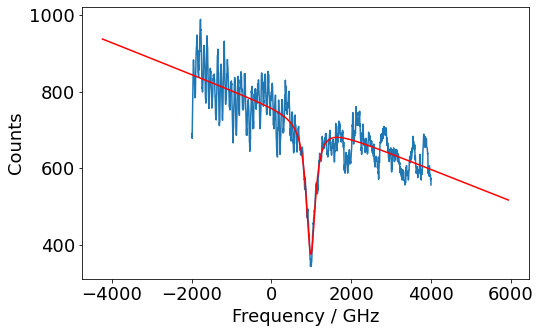

In [84]:
# Range of frequencies to filter out to remove SiV peaks
filter_range = [(-4500, -2000), (4000, 6000)]

# Filter the freq and intensity values
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

#####
params = Parameters()
params.add_many(
    Parameter('w_c', value=1000, min=800, max=1200),
    Parameter('k_in', value=100, min=50, max=1000),
    Parameter('k_tot', value=200, min=0, max=1000),
    Parameter('A', value=1000, min=500, max=2000),
    Parameter('B', value=0, vary=False),
    Parameter('m', value=-10, min=-100, max=-0.001),
)

cavity_filtered_results = tilted_cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered, method="lbfgsb")
lmfit.report_fit(cavity_filtered_results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs, tilted_cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs), 'r')
plt.xlabel("Frequency / GHz")
plt.ylabel("Counts")

## More complicated tilt

In [70]:
def tilted_cavity_ref_cub(w, w_c, k_in, k_tot, A, B, lin, quad, cub):
    return (cub * (w - w_c)**3 + quad * (w - w_c)**2 + lin * (w - w_c) + A) * Cavity.reflectance_fn(
                        w, -1, [],
                        w_c, k_in, k_tot
                        ) + B

tilted_cavity_ref_model_cub = lmfit.Model(tilted_cavity_ref_cub)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 912
    # data points      = 1207
    # variables        = 7
    chi-square         = 2290843.28
    reduced chi-square = 1909.03607
    Akaike info crit   = 9125.08456
    Bayesian info crit = 9160.75581
[[Variables]]
    w_c:    987.718800 +/- 3.59645757 (0.36%) (init = 1000)
    k_in:   110.947918 +/- 5.70067510 (5.14%) (init = 101)
    k_tot:  129.054385 +/- 6.14596259 (4.76%) (init = 200)
    A:      715.124276 +/- 2.57823521 (0.36%) (init = 1000)
    B:      0 (fixed)
    lin:   -0.04056509 +/- 0.00183255 (4.52%) (init = -10)
    quad:   1.7065e-06 +/- 5.5727e-07 (32.66%) (init = 1e-06)
    cub:   -1.5342e-10 +/- 3.1015e-10 (202.15%) (init = 1e-10)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.997
    C(lin, cub)    = -0.918
    C(A, quad)     = -0.825
    C(k_tot, A)    =  0.522
    C(k_in, A)     =  0.492
    C(k_tot, quad) = -0.404
    C(k_in, quad)  = -0.379


Text(0, 0.5, 'Counts')

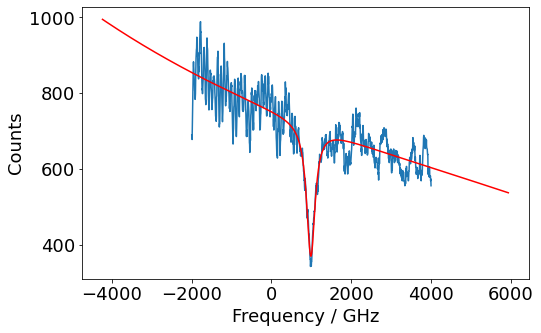

In [83]:
# Range of frequencies to filter out to remove SiV peaks
filter_range = [(-4500, -2000), (4000, 6000)]

# Filter the freq and intensity values
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

#####
params = Parameters()
params.add_many(
    Parameter('w_c', value=1000, min=800, max=1200),
    Parameter('k_in', value=101, min=50, max=1000),
    Parameter('k_tot', value=200, min=0, max=1000),
    Parameter('A', value=1000, min=500, max=2000),
    Parameter('B', value=0, vary=False),
    Parameter('lin', value=-10, min=-100, max=100),
    Parameter('quad', value=1e-6, min=-1e-2, max=1e-2),
    Parameter('cub', value=1e-10, min=-1e-6, max=1e-6),
)

cavity_filtered_results = tilted_cavity_ref_model_cub.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered, method="lbfgsb")
lmfit.report_fit(cavity_filtered_results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)

plt.plot(cavity_freqs, tilted_cavity_ref_model_cub.eval(params=cavity_filtered_results.params, w=cavity_freqs), 'r')
plt.xlabel("Frequency / GHz")
plt.ylabel("Counts")